In [1]:
import numpy as np
import qiskit
import mitiq
import matplotlib.pyplot as plt
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel
import qiskit.providers.aer.noise as noise
from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error
from qiskit import *
from qiskit import IBMQ

In [2]:
#Define the functions used to build the Trotter circuit.
def h_Z(qc,h,dt):
    for i in range(5):
        if i==0 or i==4:
            qc.rz(h*dt,i)
        else:
            qc.rz(2*h*dt,i)
        
def X_Rabi(qc,Omega,dt): # Rabi coupling
    
    for i in range(5):
        
        qc.rx(2*Omega*dt,i)
        
def ZZ(qc,V,dt): # nearest neighbor coupling
    
    qc.cx(0,1)
    
    qc.rz(-2*V*dt,1)
    
    qc.cx(0,1)
    
    qc.cx(2,3)
    
    qc.rz(-2*V*dt,3)
    
    qc.cx(2,3)
    
    qc.cx(1,2)
    
    qc.rz(-2*V*dt,2)
    
    qc.cx(1,2)
    
    qc.cx(3,4)
    
    qc.rz(-2*V*dt,4)
    
    qc.cx(3,4)

def Trotter_circuit_5_site(h,Omega,V,T,n):
    
    Trotter_circuits = []
    
    dt=T/n
    
    for i in range(n):
        
        Trotter_circuit = QuantumCircuit(5)
        
        ### Initial state setting
        
        Trotter_circuit.x(1)
        
        Trotter_circuit.x(3)
        
        ###
        
        Trotter_circuit.barrier()
        
        for k in range(i):
            X_Rabi(Trotter_circuit,Omega,dt) # Rabi coupling from the second term of Hamiltonian
            
            h_Z(Trotter_circuit,h,dt) # Z field 
            
            ZZ(Trotter_circuit,V,dt) # Nearest neighbor hopping term
            
            Trotter_circuit.barrier()
            
        Trotter_circuit.measure_all()
        
        Trotter_circuits.append(Trotter_circuit)
        
    return Trotter_circuits

In [3]:
#Parameters used for the Trotter cirucit
Omega = 0.2*2

h = 2*2

V = 1*2

T = 10 # Total time

TT=T

#NEED TO CHECK IF THIS IS ALLOWED
delta_t = .5

#CHECK THIS AS WELL
n = int(np.rint(T/delta_t))

NN=n

Trotter_circuit = Trotter_circuit_5_site(h,Omega,V,T,n)

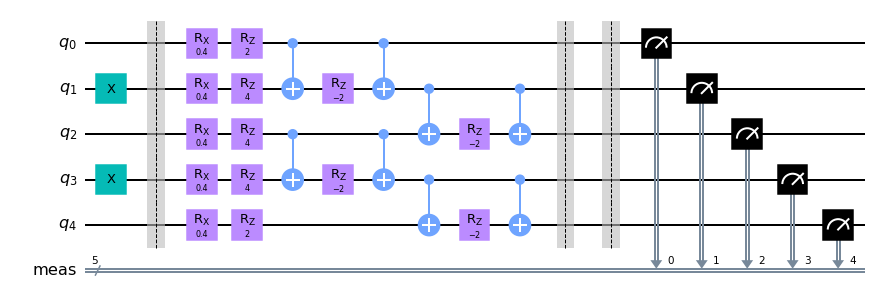

In [4]:
Trotter_circuit[1].draw(output='mpl')

In [5]:
#This cell sets up everything we need so the readout error mitigation will work.
from qiskit.test.mock import FakeVigo

backend = FakeVigo()

#This needs to be 5, since we have 5 qubits in our circuit.
qr = QuantumRegister(5)

noise_model = NoiseModel.from_backend(backend)

qubit_list = [0,1,2,3,4]

meas_calibs, state_labels = complete_meas_cal(qubit_list=qubit_list, qr=qr, circlabel='mcal')

qasm_sim = Aer.get_backend('qasm_simulator')

t_qc = transpile(meas_calibs, backend) #Aer.get_backend('qasm_simulator'))
qobj = assemble(t_qc, shots=10000)

#note that the noise model isn't used until here. All the code in this cell above this comment is
# simply doing calibration of the circuit.
cal_results = qasm_sim.run(qobj, noise_model=noise_model, shots=10000).result()

meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')

meas_filter = meas_fitter.filter

In [6]:
def post_selection(bit_str):
    """This function takes in a bitstring, and will return True iff 
    there is a 1 next to another 1 in the given bitstring.
    This does NOT consider a bitstring with 1s on either end as next to one another,
    i.e. given a string of the form '10...01', this function should return False"""
    new_str = '0' + bit_str[0:len(bit_str)]
    for i in range(0,len(bit_str)+1):
        if (new_str[i] == '1') & (new_str[i] == new_str[i-1]):
            return True
    return False

def post_selected_expval(counts, qubit):
    """This function takes in the counts from a circuit execution, as well as a qubit index, 
    and outputs <Z> for that qubit after post-selection"""
    copy_counts = counts.copy()
    
    total = []

    for x in counts.keys():
        if post_selection(x):
            copy_counts.pop(x)

    for x in copy_counts:
        total.append(copy_counts[x])

    total = sum(total)

    one_counts = 0

    for x in copy_counts.keys():
        if x[qubit] == '1':
            one_counts += copy_counts[x]

    prob = one_counts / total

    expval = 2*prob - 1
    
    return expval

In [7]:
def Z(bitstring, bit):
    """Function that takes in a bitstring, as well as a bit, and returns -1 if the specified bit in the
    bitstring is a 1. Returns 1 otherwise."""
    if bitstring[bit] == '1':
        return -1
    else:
        return 1

def ZZ_measurement(bitstring, bit1, bit2):
    """Apply the Z function to two bits, and find their product"""
    return Z(bitstring, bit1) * Z(bitstring, bit2)

def ZZ_meas_expval(counts, bit1, bit2):
    """This function takes in the counts from after a cirucit execution, then post-selects them.
    After this, <Z_i Z_{i+1}> is calculated and output."""
    copy_counts = counts.copy()
    total = []

    for x in counts.keys():
        if post_selection(x):
            copy_counts.pop(x)
    
    for x in copy_counts:
        total.append(copy_counts[x])
    
    total = sum(total)

    one_counts = 0

    for x in copy_counts.keys():
        if x[bit1] == '1':
            one_counts += copy_counts[x]

    prob = one_counts / total
    
    expval_list = []
    
    for x in copy_counts.keys():
        expval_list.append(ZZ_measurement(x,bit1,bit2) * copy_counts[x]/total)
    
    return sum(expval_list)

In [8]:
from qiskit.test.mock import FakeVigo

#Use a backend with an error model
backend = FakeVigo()

ideal_backend = Aer.get_backend('qasm_simulator')

# define the executor so mitiq will work. Note that the noise model is contained within here,
# so every time it is called, the result will be noisy.
def qiskit_multiqubit_executor(circuit, shots: 1000, qubit) -> tuple:
    """This function takes in a circuit, number of shots, and the qubit you are
    interested in, and returns either <Z_i> or <Z_i Z_{i+1}>, where i is the qubit you are intered in"""
    noise_model = NoiseModel.from_backend(backend)
    
    basis_gates = noise_model.basis_gates

    # execution of the experiment
    job = qiskit.execute(
        circuit,
        backend,
        basis_gates=basis_gates,
        # we want all gates to be actually applied,
        # so we skip any circuit optimization
        optimization_level=0,
#         noise_model=noise_model,
        shots=shots,
        seed_transpiler=1,
        seed_simulator=1
    )
    results = job.result()
    mit_results = meas_filter.apply(results)
    counts = mit_results.get_counts()
    
    output1 = post_selected_expval(counts,qubit)
    
    #This prevents an index error when calculating <Z_i Z_{i+1}>
    if qubit == 4:
        output2 = 0
    else:
        output2 = ZZ_meas_expval(counts,qubit,qubit+1)
    
    return (output1, output2)

# This executor does not use the noise model, and should give the ideal results from the circuit execution.
def ideal_qiskit_multiqubit_executor(circuit, shots: 1000, qubit) -> tuple:
    """This function takes in a circuit, number of shots, and the qubit you are
    interested in, and returns the tuple (<Z_i>, <Z_i Z_{i+1}>), 
    where i is the qubit you are interested in"""
    #noise_model = NoiseModel.from_backend(backend)
    
    #basis_gates = noise_model.basis_gates

    # execution of the experiment
    job = qiskit.execute(
        circuit,
        ideal_backend,
        #basis_gates=basis_gates,
        # we want all gates to be actually applied,
        # so we skip any circuit optimization
        optimization_level=0,
        #noise_model=noise_model,
        shots=shots,
        seed_transpiler=1,
        seed_simulator=1
    )
    results = job.result()
    ## These 2 lines MUST be commented out. Somehow, they cause the calculation of <Z_i Z_{i+1}> to be off.
#     mit_results = meas_filter.apply(results)
#     counts = mit_results.get_counts()
    counts = results.get_counts()
    
    output1 = post_selected_expval(counts,qubit)
    
    #This prevents an index error when calculating <Z_i Z_{i+1}>
    if qubit == 4:
        output2 = 0
    else:
        output2 = ZZ_meas_expval(counts,qubit,qubit+1)
    
    return (output1, output2)

In [9]:
#Check the executors are working properly

qiskit_multiqubit_executor(Trotter_circuit[1],8192,0)

# ideal_qiskit_multiqubit_executor(Trotter_circuit[3],8192,2)

(-0.9793379695820537, -0.7841955740641903)

In [10]:
from functools import partial

def non_ideal_z_expval(circuit, input_shots, input_qubit):
    return qiskit_multiqubit_executor(circuit, input_shots, input_qubit)[0]

def non_ideal_zz_expval(circuit, input_shots, input_qubit):
    return qiskit_multiqubit_executor(circuit, input_shots, input_qubit)[1]

scale_factors = [1., 2., 3.]

linear_factory = mitiq.zne.inference.LinearFactory(scale_factors)

# This function is used to calculate the mitigated counts we will use to plot our data.
def Z_zne_expval(input_shots, input_qubit, t):
    temp = partial(non_ideal_z_expval, input_shots = input_shots, input_qubit = input_qubit)
    return mitiq.execute_with_zne(Trotter_circuit[t], temp, factory = linear_factory, num_to_average = 3)

def ZZ_zne_expval(input_shots, input_qubit, t):
    temp = partial(non_ideal_zz_expval, input_shots = input_shots, input_qubit = input_qubit)
    return mitiq.execute_with_zne(Trotter_circuit[t],temp,factory = linear_factory, num_to_average = 3)

In [11]:
## This cell is used to check that all the executors and zne stuff is working properly

# non_ideal_z_expval(Trotter_circuit[1], 8192, 0)
# non_ideal_zz_expval(Trotter_circuit[1], 8192, 0)

# temp = partial(non_ideal_z_expval, input_shots = 8192, input_qubit = 0)

# print(temp(Trotter_circuit[1]))

Z_zne_expval(8192, 0, 1)
# ZZ_zne_expval(8192, 0, 1)

-0.9886564837748686

In [12]:
num_qubits = int(Trotter_circuit[0].width()/2)

ideal_z_expval_dict = {0:[], 1:[], 2:[], 3:[], 4:[]}
ideal_zz_expval_dict = {0:[], 1:[], 2:[], 3:[], 4:[]}

#populate the lists in the dictionaries with the proper expectation values
for y in range(0,len(Trotter_circuit)):
    for x in ideal_z_expval_dict:
        a = ideal_qiskit_multiqubit_executor(Trotter_circuit[y],8192,x)
        ideal_z_expval_dict[x].append(a[0])
        ideal_zz_expval_dict[x].append(a[1])

In [13]:
num_qubits = int(Trotter_circuit[0].width()/2)

z_expval_dict = {}
zz_expval_dict = {}

#Create a dictionary, where <Z> and <ZZ> is stored for each time slice and each qubit.
for y in range(0,num_qubits):
    z_expval_dict.update({y:[]})
    zz_expval_dict.update({y:[]})
    for x in range(0,len(Trotter_circuit)):
        z_expval_dict[y].append(Z_zne_expval(8192,y,x))
        zz_expval_dict[y].append(ZZ_zne_expval(8192,y,x))

In [14]:
#ideal_z_expval_dict[4]

In [15]:
# def n_i(Z_i_expval):
#     return (1 + Z_i_expval)/2


def n_i_n_iplus1(Z_i_expval,Z_iplus1_expval,prod_expval):
    """Function takes in <Z_i>, <Z_{i+1}>, and <Z_i Z_{i+1}>, and outputs <n_i n_{i+1}>."""
    return (1 + Z_i_expval + Z_iplus1_expval + prod_expval)/4

# def alternative_method(Z_i,Z_iplus1):
#     return n_i(Z_i) * n_i(Z_iplus1)

In [16]:
sum_list = []

#This loop adds up all the IDEAL values of <n_i n_{i+1}> for each time slice, then puts them in sum_list.
for x in range(len(Trotter_circuit)):
    temp_list = []
    for y in range(num_qubits-1):
        temp_list.append(n_i_n_iplus1(ideal_z_expval_dict[y][x], ideal_z_expval_dict[y+1][x],
                                     ideal_zz_expval_dict[y][x]))
    temp_sum = sum(temp_list)
    sum_list.append(temp_sum)

No handles with labels found to put in legend.


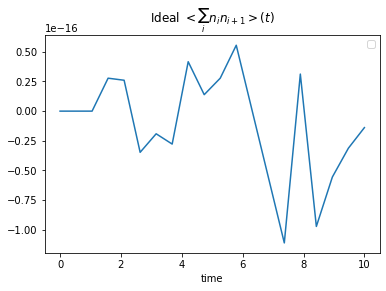

In [17]:
#create x axis for our graph
t=np.linspace(0,TT,NN)

#plot the sum of <n_i n_{i+1}>
fig,ax = plt.subplots()
ax.plot(t, sum_list)
ax.set_title('Ideal $<\sum_i n_i n_{i+1}>(t)$')
ax.set_xlabel('time')
ax.legend()

In [18]:
sum_list = []

#This loop adds up all the NON-IDEAL values of <n_i n_{i+1}> for each time slice,
# then puts them in sum_list.
for x in range(0,20):
    temp_list = []
    for y in range(0,4):
        temp_list.append(n_i_n_iplus1(z_expval_dict[y][x], z_expval_dict[y+1][x],
                                     zz_expval_dict[y][x]))
    temp_sum = sum(temp_list)
    sum_list.append(temp_sum)

No handles with labels found to put in legend.


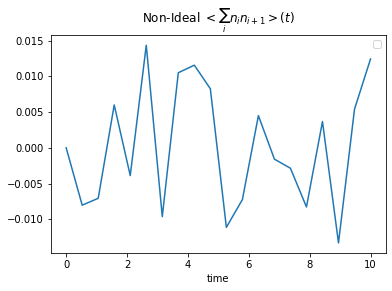

In [19]:
#create x axis for our graph
t=np.linspace(0,TT,NN)

#plot the sum of <n_i n_{i+1}>
fig,ax = plt.subplots()
ax.plot(t, sum_list)
ax.set_title('Non-Ideal $<\sum_i n_i n_{i+1}>(t)$')
ax.set_xlabel('time')
ax.legend()

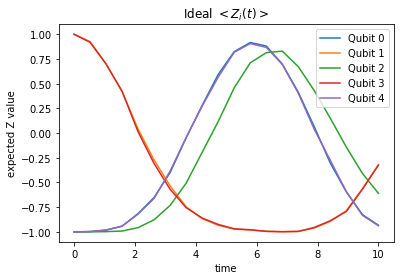

In [20]:
fig,ax = plt.subplots()
ax.plot(t, ideal_z_expval_dict[0], label='Qubit 0')
ax.plot(t, ideal_z_expval_dict[1], label='Qubit 1')
ax.plot(t, ideal_z_expval_dict[2], label='Qubit 2')
ax.plot(t, ideal_z_expval_dict[3], label='Qubit 3')
ax.plot(t, ideal_z_expval_dict[4], label='Qubit 4')
ax.set_xlabel('time')
ax.set_ylabel('expected Z value')
ax.set_title("Ideal $<Z_i(t)>$")
ax.legend()

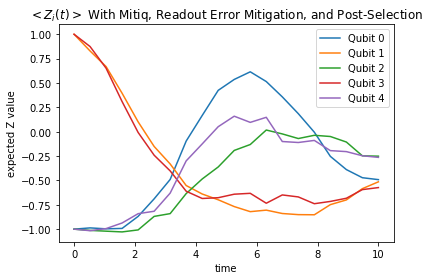

In [21]:
fig,ax = plt.subplots()
ax.plot(t, z_expval_dict[0], label='Qubit 0')
ax.plot(t, z_expval_dict[1], label='Qubit 1')
ax.plot(t, z_expval_dict[2], label='Qubit 2')
ax.plot(t, z_expval_dict[3], label='Qubit 3')
ax.plot(t, z_expval_dict[4], label='Qubit 4')
ax.set_xlabel('time')
ax.set_ylabel('expected Z value')
ax.set_title("$<Z_i(t)>$ With Mitiq, Readout Error Mitigation, and Post-Selection")
ax.legend()